In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


from pathlib import Path

import gc
import time

from utils import *

from sklearn.ensemble import RandomForestClassifier

seed=42
PATH = Path('data')
list(PATH.iterdir())

[PosixPath('data/train_no_att_time.csv'),
 PosixPath('data/submission'),
 PosixPath('data/train_day8_3to16_FE.feather'),
 PosixPath('data/train_df_10mil_fe_v1.feather'),
 PosixPath('data/sample_submission.csv'),
 PosixPath('data/train_day9_3to16_FE.feather'),
 PosixPath('data/train_sample.csv'),
 PosixPath('data/train_day7_3to16_FE.feather'),
 PosixPath('data/dtree.dot'),
 PosixPath('data/test_FE.feather'),
 PosixPath('data/val_idxs.p'),
 PosixPath('data/mean_enc_df'),
 PosixPath('data/test_nextclick.feather'),
 PosixPath('data/validation')]

In [2]:
def metric(rf,X_val,y_val):
    y_val_pred = rf.predict_proba(X_val)[:,1]
    return roc_auc_score(y_val,y_val_pred)

def permutation_importances(rf,X_val,y_val,metric):
    baseline = metric(rf,X_val,y_val)
    imp=[]
    for col in X_val.columns:
        save = X_val[col].copy()
        X_val[col] = np.random.permutation(X_val[col])
        m = metric(rf,X_val,y_val)
        print(f'Score after {col} perm: {m:.5f}')
        X_val[col] = save
        imp.append(baseline-m)
    return np.array(imp)

def get_sample_timeseries(filename,sz):
    df = get_feather(filename)
    sample_idx =np.random.permutation(df.shape[0])
    sample_idx=sorted(sample_idx[:sz])
    df = df.loc[sample_idx,:].reset_index().drop('index',axis=1)
    gc.collect()
    return df

In [3]:
def prediction_score(rf,train_df,y_train,val_df,y_val):
    y_train_pred = rf.predict_proba(train_df)[:,1]
    print(f'Train AUC: {roc_auc_score(y_train, y_train_pred)}')
    y_val_pred = rf.predict_proba(val_df)[:,1]
    val_auc = roc_auc_score(y_val, y_val_pred)
    print(f'Val AUC: {roc_auc_score(y_val, y_val_pred)}')
    return val_auc

In [4]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

val_losses=[]
def score(params):
    print("Training with params: ")
    print(params)
    
    rf = RandomForestClassifier(oob_score=False,n_jobs=-1,class_weight={1:100},random_state=seed,**params)
    rf.fit(train_df,y_train)
    loss=prediction_score(rf,train_df,y_train,val_df,y_val)
    val_losses.append(loss)
    del rf
    gc.collect()
    return {'loss': loss, 'status': STATUS_OK}

def optimize(space,max_evals=5):
    
    best = fmin(score, space, algo=tpe.suggest, 
        # trials=trials, 
        max_evals=max_evals)
    return best

ModuleNotFoundError: No module named 'hyperopt'

# Get data


In [5]:
cols_to_drop=['is_attributed','ip','day']

In [6]:
sz = 3000000
train_df=get_sample_timeseries('train_day8_3to16_FE.feather',sz)

In [5]:
# 4 folds
# val_df = get_feather('train_day9_3to16_FE.feather')
# val_idxs = get_cv_idxs(val_df.shape[0],4)
# pickle.dump( val_idxs, open(PATH/"val_idxs.p", "wb" ) )

In [6]:
# val_idxs = pickle.load( open(PATH/"val_idxs.p", "rb" ) )

In [8]:
# for i,v in enumerate(val_idxs):
#     temp = val_df.loc[v,:].reset_index().drop('index',axis=1)
#     gc.collect()
#     temp.to_feather(PATH/'validation'/ f'val{i}.feather')

21

28

28

28

In [7]:
# sz = 20000000
# val_df=get_sample_timeseries('train_day9_3to16_FE.feather',sz)

In [10]:
y_train = train_df.is_attributed
train_df.drop(cols_to_drop,axis=1,inplace=True)
gc.collect()

7

In [8]:
# y_val = val_df.is_attributed
# val_df.drop(cols_to_drop,axis=1,inplace=True)
# gc.collect()

14

# Hyperparam tuning

In [13]:
space = {
    'max_features': hp.quniform('max_features', 0.3, 1, 0.1),
    'max_depth': hp.choice('max_depth', np.arange(7,20,dtype=int)),
    'n_estimators': hp.choice('n_estimators', np.arange(7,40,dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(5,100,dtype=int))
}
best_hyperparams = optimize(space,max_evals=50)
print("The best hyperparameters are: ")
print(best_hyperparams)

Training with params: 
{'max_depth': 15, 'max_features': 0.4, 'min_samples_leaf': 52, 'n_estimators': 39}
Train AUC: 0.9970457162460779
Val AUC: 0.9479758210890826
Training with params: 
{'max_depth': 13, 'max_features': 0.7000000000000001, 'min_samples_leaf': 17, 'n_estimators': 7}
Train AUC: 0.9906067985910008
Val AUC: 0.9361428470272555
Training with params: 
{'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 86, 'n_estimators': 7}
Train AUC: 0.9826785070613309
Val AUC: 0.9555491526913718
Training with params: 
{'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 15, 'n_estimators': 11}
Train AUC: 0.9793016152259189
Val AUC: 0.9547558962546583
Training with params: 
{'max_depth': 12, 'max_features': 0.4, 'min_samples_leaf': 83, 'n_estimators': 21}
Train AUC: 0.9908104029077242
Val AUC: 0.949875743047418
Training with params: 
{'max_depth': 18, 'max_features': 0.9, 'min_samples_leaf': 11, 'n_estimators': 12}
Train AUC: 0.9986092901772153
Val AUC: 0.9217822364999013
Train

Train AUC: 0.9788281917995567
Val AUC: 0.9551969491874706
Training with params: 
{'max_depth': 18, 'max_features': 0.6000000000000001, 'min_samples_leaf': 47, 'n_estimators': 8}
Train AUC: 0.9976740660947593
Val AUC: 0.926757962548866
The best hyperparameters are: 
{'max_depth': 12, 'max_features': 0.30000000000000004, 'min_samples_leaf': 1, 'n_estimators': 1}


# Testing best params on 4 folds

{'max_depth': 8, 'max_features': 0.6000000000000001, 'min_samples_leaf': 51, 'n_estimators': 35}
Train AUC: 0.9798743216071168
Val AUC: 0.9576770717914608
[0.9566921458269793, 0.95697989921035, 0.956823844234881, 0.9558319439207634]
0.9565819582982433


{'max_depth': 9, 'max_features': 0.8, 'min_samples_leaf': 18, 'n_estimators': 11}
Train AUC: 0.9809579987868275
Val AUC: 0.9569033639738755
[0.9559560854868663,
 0.9564844911022952,
 0.9564030268920405,
 0.9553017816216942]
0.956036346275724


{'max_depth': 7, 'max_features': 0.5, 'min_samples_leaf': 13, 'n_estimators': 36}
Train AUC: 0.9780510959808768
Val AUC: 0.956680096628987
[0.9578717989258204, 0.9583846931359772, 0.958645910224487, 0.9577675718402391]
0.958167493531631

{'max_depth': 8, 'max_features': 0.30000000000000004, 'min_samples_leaf': 33, 'n_estimators': 30}
Train AUC: 0.979917457122492
Val AUC: 0.9568484424986683
[0.956181269019988, 0.9560286500196477, 0.9565709501420311, 0.9554181529392235]
0.9560497555302225



# Fixing columns problem

{'max_depth': 8, 'max_features': 0.6000000000000001, 'min_samples_leaf': 51, 'n_estimators': 35}
[0.9654080503355329, 0.9655023997757216, 0.9661937015981268, 0.96543727481057]
0.9656353566299878. Leaderboard: 0.9635 (only train on day 8)


{'max_depth': 9, 'max_features': 0.8, 'min_samples_leaf': 18, 'n_estimators': 11}
[0.9641039669595549, 0.96399024400902, 0.9647378577167327, 0.9641094643256867]
0.9642353832527486


{'max_depth': 7, 'max_features': 0.5, 'min_samples_leaf': 13, 'n_estimators': 36}
[0.964769836206739, 0.9648433416897317, 0.965350934508006, 0.9644309617411773]
0.9648487685364135


{'max_depth': 8, 'max_features': 0.30000000000000004, 'min_samples_leaf': 33, 'n_estimators': 30}
[0.9646195998140699, 0.9647027256129181, 0.9651638277544395, 0.9643861790719258]
0.9647180830633384



In [11]:
val_names = [str(i) for i in list((PATH/'validation').iterdir())]
val_names

['data/validation/val3.feather',
 'data/validation/val2.feather',
 'data/validation/val0.feather',
 'data/validation/val1.feather']

In [36]:
params ={'max_depth': 8, 'max_features': 0.6000000000000001, 'min_samples_leaf': 51, 'n_estimators': 35}
rf = RandomForestClassifier(oob_score=False,n_jobs=-1,class_weight={1:100},random_state=seed, **params)
rf.fit(train_df,y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=8, max_features=0.6000000000000001,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=51,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [28]:
mean_auc=[]
for i in val_names:
    val_df = pd.read_feather(i)
    y_val = val_df.is_attributed
    val_df.drop(cols_to_drop,axis=1,inplace=True)
    gc.collect()
    
    auc_score = prediction_score(rf,train_df,y_train,val_df,y_val)
    mean_auc.append(auc_score)
    
    del val_df,y_val
    gc.collect()
    
mean_auc
np.mean(mean_auc)

27

Train AUC: 0.9787541766656299
Val AUC: 0.9654080503355329


26

21

Train AUC: 0.9787541766656299
Val AUC: 0.9655023997757216


26

21

Train AUC: 0.9787541766656299
Val AUC: 0.9661937015981268


26

21

Train AUC: 0.9787541766656299
Val AUC: 0.96543727481057


26

[0.9654080503355329, 0.9655023997757216, 0.9661937015981268, 0.96543727481057]

0.9656353566299878

# Visualize trees

In [37]:
from IPython.display import display
from sklearn.tree import export_graphviz
import IPython,graphviz
import re
import matplotlib.pyplot as plt

In [40]:
dotfile = open(PATH/'dtree.dot', 'w')
dtree=rf.estimators_[0]
export_graphviz(dtree, out_file = dotfile, feature_names = train_df.columns,rotate=True)
dotfile.close()

# Open dot file and paste it to http://webgraphviz.com/

# Feature importances

277

Score after app perm: 0.96536
Score after device perm: 0.96541
Score after os perm: 0.96537
Score after channel perm: 0.96538
Score after hour perm: 0.96485
Score after ip_next_click perm: 0.96532
Score after ip_app_next_click perm: 0.96535
Score after ip_channel_next_click perm: 0.96537
Score after ip_os_cumcount perm: 0.96548
Score after ip_app_cumcount perm: 0.96530
Score after ip_device_os_app_cumcount perm: 0.96539
Score after ip_cumcount perm: 0.96478
Score after ip_app_os_count_channel perm: 0.96432
Score after ip_app_day_hour_count_channel perm: 0.96455
Score after app_AvgViewPerDistinct_ip perm: 0.96538
Score after ip_count_channel perm: 0.96023
Score after app_count_channel perm: 0.96533
Score after channel_count_app perm: 0.96543
Score after ip_device_os_size_None perm: 0.96515
Score after ip_device_os_app_size_None perm: 0.96464
Score after minute perm: 0.96539
Score after second perm: 0.96544
Score after app_channel_mean_target_prevday_alpha1 perm: 0.95865
Score after app_

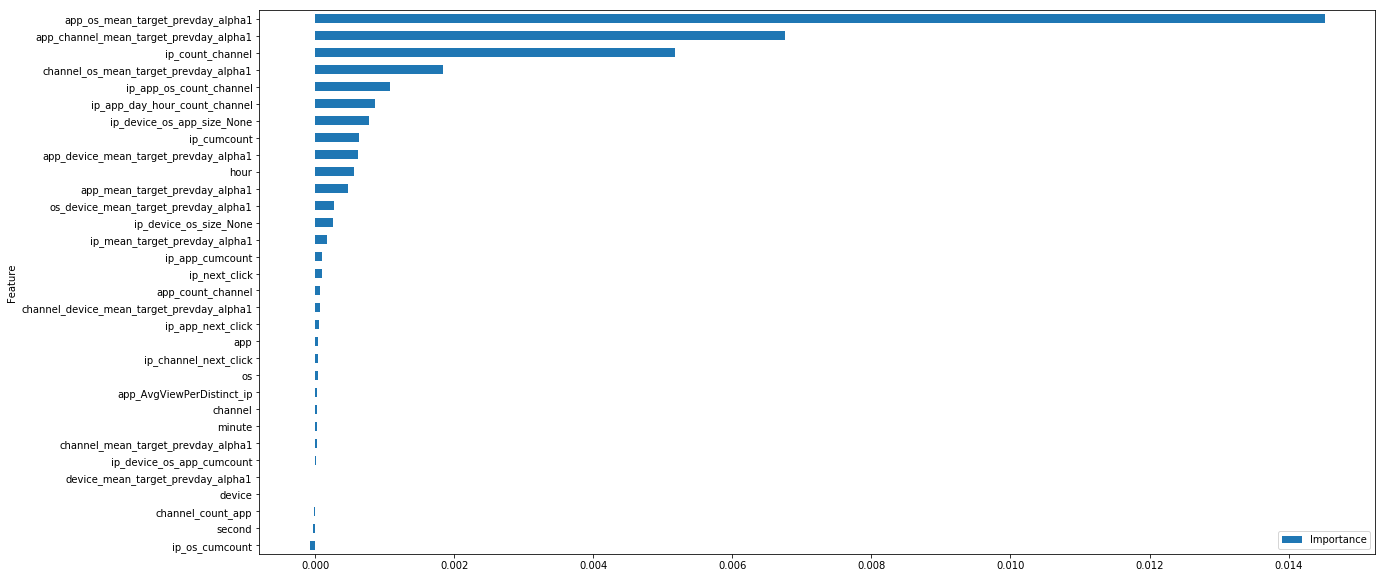

In [41]:

val_df = pd.read_feather('data/validation/val3.feather')
y_val = val_df.is_attributed
val_df.drop(cols_to_drop,axis=1,inplace=True)
gc.collect()

fea_imp = permutation_importances(rf,val_df,y_val,metric)
fea_imp_df = pd.DataFrame(data={'Feature':val_df.columns,'Importance':fea_imp})
fea_imp_df = fea_imp_df.set_index('Feature')
fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
fea_imp_df.plot(kind='barh',figsize=(20,10))






# Checking redundant featuers

In [45]:
from scipy.cluster import hierarchy as hc
import scipy

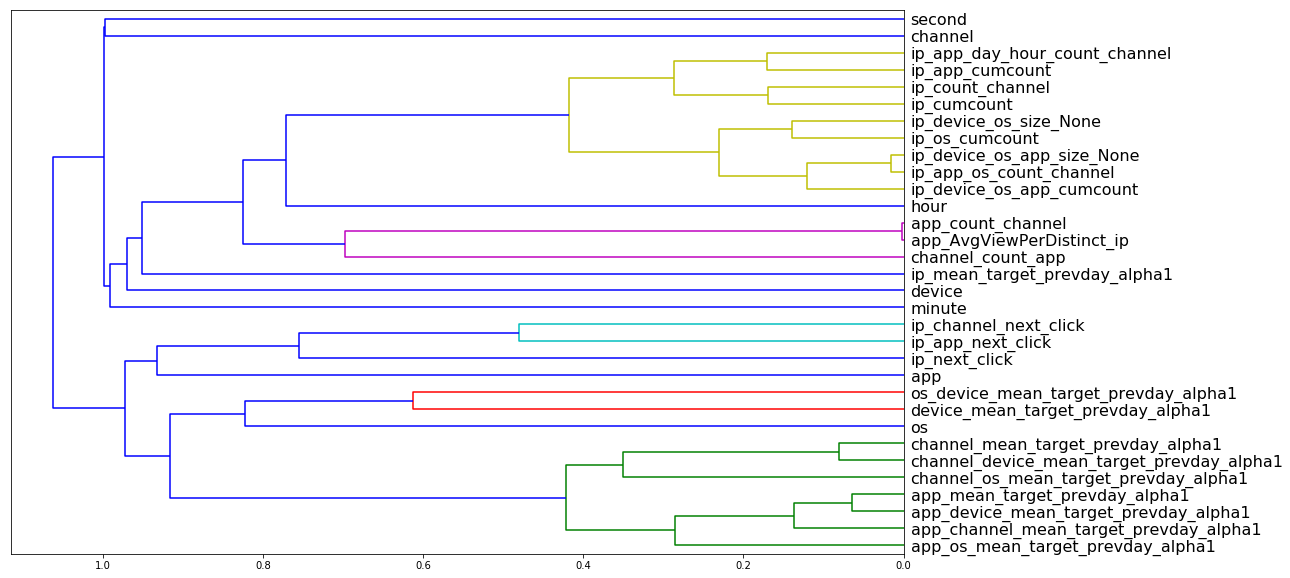

In [46]:
corr = np.round(scipy.stats.spearmanr(train_df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=train_df.columns, orientation='left', leaf_font_size=16)
plt.show()

# Remove redundant and low important features

In [12]:
params ={'max_depth': 8, 'max_features': 0.6000000000000001, 'min_samples_leaf': 51, 'n_estimators': 35}
rf = RandomForestClassifier(oob_score=False,n_jobs=-1,class_weight={1:100},random_state=seed, **params)
rf.fit(train_df,y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=8, max_features=0.6000000000000001,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=51,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [13]:
mean_auc=[]
for i in val_names:
    val_df = pd.read_feather(i)
    y_val = val_df.is_attributed
    val_df.drop(cols_to_drop,axis=1,inplace=True)
    gc.collect()
    
    auc_score = prediction_score(rf,train_df,y_train,val_df,y_val)
    mean_auc.append(auc_score)
    
    del val_df,y_val
    gc.collect()
    
mean_auc
np.mean(mean_auc)

27

Train AUC: 0.979413942215402
Val AUC: 0.9650259175823335


26

21

Train AUC: 0.979413942215402
Val AUC: 0.9653281777299716


26

21

Train AUC: 0.979413942215402
Val AUC: 0.9658650058239961


26

21

Train AUC: 0.979413942215402
Val AUC: 0.964927805062447


26

[0.9650259175823335, 0.9653281777299716, 0.9658650058239961, 0.964927805062447]

0.9652867265496872

# Test prediction (train on day 8 and 9)

In [4]:
cols_to_drop=['is_attributed','ip','day']

sz = 10000000
train_df=get_sample_timeseries('train_day8_3to16_FE.feather',sz)

In [6]:
val_df = pd.read_feather('data/validation/val3.feather')

In [8]:
train_df = pd.concat([train_df,val_df])

In [11]:
train_df = train_df.reset_index().drop('index',axis=1)

In [18]:
y_train = train_df.is_attributed
train_df.drop(cols_to_drop,axis=1,inplace=True)
gc.collect()

84

In [20]:
params ={'max_depth': 8, 'max_features': 0.6000000000000001, 'min_samples_leaf': 51, 'n_estimators': 35}
rf = RandomForestClassifier(oob_score=False,n_jobs=-1,class_weight={1:100},random_state=seed, **params)
rf.fit(train_df,y_train)

RandomForestClassifier(bootstrap=True, class_weight={1: 100},
            criterion='gini', max_depth=8, max_features=0.6000000000000001,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=51,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=35, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [21]:
train_df.shape

(20886724, 32)

In [22]:
del train_df
gc.collect()

26

In [23]:
sub = pd.read_csv(PATH/'sample_submission.csv')

test = get_feather('test_FE.feather')

test.drop(cols_to_drop[1:],axis=1,inplace=True)

In [24]:
test.shape

(18790469, 32)

In [25]:
pred = rf.predict_proba(test)[:,1]
sub.is_attributed = pred

In [26]:
sub.tail()

,click_id,is_attributed
18790464,18790464,0.156562
18790465,18790465,0.004738
18790466,18790467,0.025312
18790467,18790466,0.065722
18790468,18790468,0.003754


In [27]:
sub.to_csv(PATH/'submission'/'best_RF_day89.csv',index=False)